# Objective:

Predict past mobility patterns for Mexican Telco users using approximately 9bn CDRs (call detail records) from January 2014 to September 2015.

Input data comes in *SimpleFormat* which has following header:
 {'USER':np.int32 \\\  'OTHER_USER':np.uint32 \\\ 'DIRECTION':np.bool \\\  'TimeStamp':np.uint32 \\\   'Duration':np.uint16 \\\  'AntennaID':np.uint16}

In [2]:
!zcat /grandata/simple_format/simple_format_201401.txt.gz | head

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
USER OTHER_USER DIRECTION TIMESTAMP DURATION ANTENNA_ID
216E0E920C0B51093276E270CC36CB72 BA694194F2CF7978466AA9602DD38F36 O 63161302 56 1
216E0E920C0B51093276E270CC36CB72 BA694194F2CF7978466AA9602DD38F36 O 63162373 88 1
216E0E920C0B51093276E270CC36CB72 BCE827A6E83B59F75031D4FCEC36B7DD I 63217965 600 2
216E0E920C0B51093276E270CC36CB72 BCE827A6E83B59F75031D4FCEC36B7DD I 63218508 63 2
216E0E920C0B51093276E270CC36CB72 BCE827A6E83B59F75031D4FCEC36B7DD I 63217516 93 2
216E0E920C0B51093276E270CC36CB72 EADDE544AB1EC4B975AE41337ACFB5B5 I 63228387 35 2
73C2C1F8233884659CC65DF58BA2D031 39ABF1E2D91107D64EE4B6719C2D6C60 O 63286717 342 3
73C2C1F8233884659CC65DF58BA2D031 995362BDBB319FB4E367EB52E2540CC7 O 63280397 33 4
73C2C1F8233884659CC65DF58BA2D031 9D0AFC1877F147C63E235CF25B42CC0B O 63307690 38 4

gzip: stdout: Broken pipe


### Some observations on SimpleFormat:
* Timestamp is measured in seconds sinc 01/01/2012 00:00am
* For each call, the hash in the USER column is the one using that specific ANTENNA_ID. This means that the USER columns is only for Telco Users.
* Direction is relative to the first column too.

## SumLinks processing:
SimpleFormat data is processed to another more graph-oriented representation called SumLinks.
It's head is:

In [3]:
!zcat /grandata/voice/sum_links/sum_links_201401_201403.txt.gz | head

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
LineKeyOrigin|LineKeyTarget|CallsWeekDaylight|CallsWeekNight|CallsWeekend|TimeWeekDaylight|TimeWeekNight|TimeWeekend|SmsWeekDaylight|SmsWeekNight|SmsWeekend
BA3439E244F09BFA85F03750D84DB1B7|5AA26ADB35AF1A26A635B7747320732F|1|0|0|44|0|0|0|0|0
BA3439E244F09BFA85F03750D84DB1B7|503D0DC95765D42BE5CFB3C50075214A|1|1|0|78|313|0|0|0|0
BA3439E244F09BFA85F03750D84DB1B7|EA6C583D0F31F6D2A1E23B55334DF494|0|0|2|0|0|98|0|0|0
73F169CBB3B6E443B896017C51B1C600|9D0AFC1877F147C63E235CF25B42CC0B|1|4|4|6|85|55|0|0|0
7A0B5B991DD1B3C6E1498C07EF02FD31|9D0AFC1877F147C63E235CF25B42CC0B|0|2|5|0|146|268|0|0|0
EA23ADE2371B8D5FB02A8DDBAF5A53B2|9D0AFC1877F147C63E235CF25B42CC0B|2|1|0|147|46|0|0|0|0
BC834644645F540C1BD72307A5BD5B96|9D0AFC1877F147C63E235CF25B42CC0B|0|0|1|0|0|9|0|0|0
3C43E7D3B99947C9C0C21BA7D387F26A|9D0AFC1877F147C63E235CF25B42CC0B|1|2|0|7|142|0|0|0|0
97B89BED4B7123F6F6F47B41403C4DF1|9D0AFC1877F147C63E235CF25B42CC0B|0|1|0|0|48|0|0|

### Some observations on SumLinks:
* Each row represents a pair of interacting users where the communication direction is taken into account i.e. interactions from USER i to USER j (i --> j) are in most cases different to those from j --> i.
* All *Calls* columns are counts of communications made during different weekly or daily timespans. 
* *Time* columns are measured in seconds.
* SMS columns where not taken into account later during the data processing.
* Daylight corresponds to the [8 19) timeframe (using Mexico's central timezone)
* Telco Users are not exclusive to any of the first two columns. This means that hash pairs can or not be Telco Users.

## Antenna Tagging:

Predicting mobility patterns means that users' must be geolocated in some way. The CDRs enables us to approximately geolocate TelCo users in space every time a call is made taking into account the antenna's geolocation. 

Now if we want to predict mobility patterns from area A to B, we must then tag antennas as belonging to one of the corresponding areas. For this particular project we relied on epidemiological data to select those mexican states with highest Chagas prevalence. These were tagged as the "epidemic" states.

# SimpleFormat Data Processing:
Considering the previous details, we ran scripts through the whole dataset looking for features which will be later fed to the Machine Learning models. The idea is to construct a dataframe which has TelCo users as rows and different communication patterns as features.

To do so, we considered users on the last five months of the dataset (May through September) who used the phone in between 25 and 2000 times during this time period.

Scooping the SimpleFormat to get the following data:
* Which are the 10 most frequently used antennas for each TelcoUser, measured by counts usage. The most used antenna will be then considered the user's home antenna.
* Tag a users as EPIDEMIC (boolean data structure) if his home antenna is from the epidemic region and EXPOSED if he has been seen at least once using an EPIDEMIC antenna.
* Given the convex hull formed by the geolocations of his 10 most used antennas, get the MOBILITY_DIAMETER as the hull's diameter.


In [20]:
!head mexico_ant2vuln_aggregation.txt

ANTENNA_ID_0|TOTAL_Origin_USERS|EPI_Target_USERS|EXP_Target_USERS|CallsWeekDaylight|CallsWeekNight|CallsWeekend|TimeWeekDaylight|TimeWeekNight|TimeWeekend|CallsWeekDaylight_EPI|CallsWeekNight_EPI|CallsWeekend_EPI|TimeWeekDaylight_EPI|TimeWeekNight_EPI|TimeWeekend_EPI|TOTAL_Target_USERS|EXP_Origin_USERS
1|862|454|2059|9025|4822|4626|46644|19535|60938|3806|1983|1905|32990|14516|56277|1925|862
2|1106|487|2188|10179|6288|5937|30827|17458|26991|3720|2071|2114|29523|61293|61995|2031|1106
3|948|523|2238|15745|7418|6735|2725|5040|11032|5659|2737|2339|37832|26111|59264|2106|948
4|629|302|1502|6096|3465|3707|14516|60801|52073|3144|1622|1693|48158|47859|32960|1327|629
5|506|318|1384|5216|3115|3337|26281|57672|63254|2196|1419|1529|39912|47036|36068|1310|506
6|590|368|1399|7464|3728|3759|48537|38126|30242|3740|1754|1842|2068|633|17030|1316|590
7|1763|1106|3774|17473|9890|11105|5011|58275|23365|9311|5576|5866|43705|5905|4897|3362|1763
8|2362|1769|6084|27550|15947|16169|10812|65255|51467|17400|9925|9

In [2]:
!zcat mexico_ant2ant_aggregation.txt.gz | head

ANTENNA_ID_0|ANTENNA_ID_0_Target|CallsWeekDaylight|CallsWeekNight|CallsWeekend|TimeWeekDaylight|TimeWeekNight|TimeWeekend
1|2|0|1|0|0|127|0
1|4|2|0|4|344|0|226
1|5|7|0|2|501|0|60
1|6|488|214|244|61166|40438|31610
1|8|83|27|28|6214|2968|4341
1|9|0|0|3|0|0|194
1|10|19|2|1|1109|64|47
1|11|0|0|1|0|0|41
1|12|1|3|0|340|448|0

gzip: stdout: Broken pipe


# SumLinks Data Processing:

We'd like to know how many of each users' interactions are vulnerable(epidemic) vs the total interactions. To do so, it's convenient to view antennas as partitions in the graph of user interactions considering that each user is mapped to his home antenna. In this graph, users are nodes and edges mean that at least 1 interaction is present between those 2 users.

Here we can also extract information at the antenna level. 
* Having Total_Origin_USERS as the number of nodes in that antenna, 
* Total_Target_USERS as the number of nodes from other antennas which are connected to this antenna,
* EPIDEMIC_Target_users as the amount of outer-edges (where one of the edge's nodes is from a different antenna) coming from EPIDEMIC antennas,
* EXPOSED_Target_users which is similar to the case before but where other users are EXPOSED only.
* 

At the user level exctracted the following information from the SumLinks files:
* Get count of total Calls and Time of phone usage per user. Also get count of total EPIDEMIC Calls and Time of phone usage per user.
* Get the number of nodes interacting with this user, with specific disaggregation for epidemic and exposed nodes.

# Ground Truth

We're intending to predict if a user has been living in a certain area during the past period (January 2014 to April 2015). Specifically looking for users that used to live in epidemic areas during the past i.e. we're trying to label users as having lived in epidemic areas during the past period. 

As such, we need to identify the most frequently used antenna for each user during the past period in order to target its "epidemicity". As knowing if a user was exposed in the past directly followed from this same analysis, this information was recorded as well

## Below
are the output files for the different processing scripts

In [36]:
## seteamos los parametros del notebook
%autosave 180

import pandas as pd; 
import numpy as np; 
import os;
import random;
import time
import matplotlib
%matplotlib inline
import sys


np.random.seed(2015)
rootdir=os.getcwd()
rootdir+= "/datasets"
os.chdir(rootdir)

Autosaving every 180 seconds
This non-commercial license of GraphLab Create is assigned to svega@dm.uba.ar and will expire on April 16, 2017. For commercial licensing options, visit https://dato.com/buy/.


2016-04-22 03:24:36,959 [INFO] graphlab.cython.cy_server, 176: GraphLab Create v1.8.5 started. Logging: /tmp/graphlab_server_1461295476.log


OSError: [Errno 2] No such file or directory: '/home/juan/mobility-study/datasets/datasets'

In [41]:
start_time = time.time()

file_sf = "sf_output.txt.gz"
file_sl = "sl_output.txt.gz"
file_gt = "ground_truth.csv.gz"
file_ant = "../mexico_ant2vuln_aggregation.txt"

sf_sframe = pd.read_csv(file_sf,sep = ",",
                   header = 0,
                     index_col =None,
                       nrows =10)
sl_sframe = pd.read_csv(file_sl,sep = "|",
                   header = 0,
                     index_col = None,
                       nrows =10)
sl_sframe.columns = ["USER" if ("LineKeyOrigin" in col) else col for col in sl_sframe.columns  ]

gt_sframe = pd.read_csv(file_gt,sep = "|",
                   header = 0,
                     index_col = None,
                       nrows =10)

ant_sframe = pd.read_csv(file_ant,sep = "|",
                   header = 0,
                     index_col =None)

#agrego la etiqueta "_gt" a las columnas del ground_truth
gt_sframe.columns = [col+"_gt" if not("USER" in col) else col for col in gt_sframe.columns  ]

all_time =   time.time() - start_time

print('This cell took %s seconds to run' % all_time)

This cell took 0.0375061035156 seconds to run


# SF output Head

In [7]:
sf_sframe.head()

,USER,EXPOSED,ANTENNA_ID_0,COUNT_0,ANTENNA_ID_1,COUNT_1,ANTENNA_ID_2,COUNT_2,ANTENNA_ID_3,COUNT_3,...,ANTENNA_ID_6,COUNT_6,ANTENNA_ID_7,COUNT_7,ANTENNA_ID_8,COUNT_8,ANTENNA_ID_9,COUNT_9,EPIDEMIC,MOBILITY_DIAMETER
0,FFFF78CB080636632B2D1DE7A7BFAB03,False,3415,21,2969,5,1320,3,2471,3,...,-1,65535,-1,65535,-1,65535,-1,65535,False,1063.140535
1,FFFF51FDDD55A2E24D074DE30C4798E9,True,1207,15,1171,14,1820,9,583,8,...,1831,4,1625,2,401,1,825,1,False,520.065959
2,FFFE1EDDA25369CBC467536FA6A787FD,True,1847,22,1753,14,1422,11,1028,10,...,862,8,2463,7,1416,6,871,5,True,989.597851
3,FFFD0A912A959CDFCFFAB2F93BFBA435,True,1407,18,1702,8,1613,6,1704,5,...,818,2,958,2,726,1,848,1,False,490.585382
4,FFFCB235D6D917DDF350F5B11CCB0EE8,True,17,74,174,33,1123,4,1178,4,...,503,1,1039,1,1228,1,1327,1,True,1613.225606


# SL output Head

In [6]:
sl_sframe.head()

,USER,CallsWeekDaylight,CallsWeekDaylight_EPI,CallsWeekNight,CallsWeekNight_EPI,CallsWeekend,CallsWeekend_EPI,TimeWeekDaylight,TimeWeekDaylight_EPI,TimeWeekNight,TimeWeekNight_EPI,TimeWeekend,TimeWeekend_EPI,TOTAL_USERS,EPI_USERS,EXP_USERS
0,000004F96010462FA7A71C7784E27476,0,0,0,0,0,1,0,0,0,0,0,34,1,0,1
1,000007EEE7895E17937CFF86379C8E17,0,2,0,0,0,0,0,144,0,0,0,0,1,1,1
2,00000837B868F926F67BD440A0845C1D,1,0,2,4,3,0,47,0,74,86,109,0,3,0,2
3,00000C5D3BFBEBD919F6F68386C3DD5E,4,0,0,0,0,0,281,0,0,0,0,0,1,0,1
4,0000129F4191FFD0963774D2307C7510,2,0,0,0,0,0,66,0,0,0,0,0,2,0,2


## Antenna Aggregation HEAD

In [31]:
ant_sframe.head()

,ANTENNA_ID_0,TOTAL_Origin_USERS,EPI_Target_USERS,EXP_Target_USERS,CallsWeekDaylight,CallsWeekNight,CallsWeekend,TimeWeekDaylight,TimeWeekNight,TimeWeekend,CallsWeekDaylight_EPI,CallsWeekNight_EPI,CallsWeekend_EPI,TimeWeekDaylight_EPI,TimeWeekNight_EPI,TimeWeekend_EPI,TOTAL_Target_USERS,EXP_Origin_USERS
0,1,862,454,2059,9025,4822,4626,46644,19535,60938,3806,1983,1905,32990,14516,56277,1925,862
1,2,1106,487,2188,10179,6288,5937,30827,17458,26991,3720,2071,2114,29523,61293,61995,2031,1106
2,3,948,523,2238,15745,7418,6735,2725,5040,11032,5659,2737,2339,37832,26111,59264,2106,948
3,4,629,302,1502,6096,3465,3707,14516,60801,52073,3144,1622,1693,48158,47859,32960,1327,629
4,5,506,318,1384,5216,3115,3337,26281,57672,63254,2196,1419,1529,39912,47036,36068,1310,506


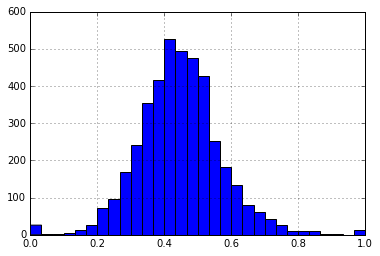

In [42]:
((ant_sframe['TOTAL_Origin_USERS'] -ant_sframe['EPI_Target_USERS'])/ant_sframe['TOTAL_Origin_USERS']).hist(bins=30)

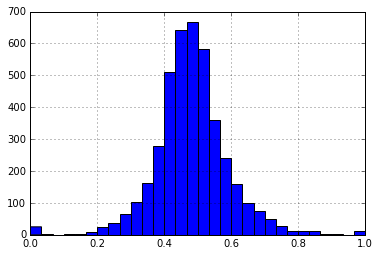

In [40]:
((ant_sframe['TOTAL_Origin_USERS'] -ant_sframe['EPI_Target_USERS'])/ant_sframe['TOTAL_Origin_USERS']).hist(bins=30)

In [8]:
# para poder usar el estimador MultionmialNB, paso todos los valores negativos en las antenna_ids de sf_table a 0
for col in [col for col in sf_sframe.columns.values if "_ID" in col]:
    sf_sframe[col] = sf_sframe[col].replace(-1,0)

# Ground Truth Head

In [24]:
gt_sframe.head()

,USER,ANTENNA_ID_gt,EPIDEMIC_gt,EXPOSED_gt
0,FFFF51FDDD55A2E24D074DE30C4798E9,470,0,0
1,FFFC3133FAEF588B9FA75487C864F774,1036,0,1
2,FFFB2F18F4CCF253C06B581EA518A7A5,497,1,1
3,FFFB2C0FEE677EE733DDD85F11C5A14C,214,0,1
4,FFFB27D77413E57C38D14D876C3DE8CF,2946,0,1
